# Toy examples using Stan (1950+)

I estimate the Preston, box-cox, and log quadratic model using data from 1950+. Are these models comparable? No, but the Jacobian adjustment should do the trick. I am not sure if I am doing the correct thing, need some math assistance.

Next steps: 

- Check if my adjustment of the log-likelihood to make models comparable is correct. For instance: 

  ```log_lik[n] = normal_lpdf((y[n]^lambda - 1)/lambda | alpha + log(x[n])*beta, sigma) + (lambda-1)*log(y[n]);```
  
- Find a solution for invalid box-cox posterior values: for now, some outcome transformation, and post-processing posterior sampled values. You might have better ideas on the transformations we can do. 
- Create function to average predictions using stacking weights
- Think about reasonable priors to use
- Which LE estimates to use?
- Function to compute delta values
- Get distribution of final estimates 

Something else?

In [26]:
# libraries
library(rstan)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
library(brms)
library(loo)
library(haven)
library(sdazar)
library(data.table)
library(MASS)

library(ggplot2)
library(patchwork)
options(repr.plot.width = 5, repr.plot.height = 3)
source('Rutils/functions.R')

## Using real data (1950 or more)

In [27]:
# load data

df = data.table(read_stata('../data/LA_uncertainty.dta'))
df = df[, .(ctry, year, gdp_pc, median)]
setnames(df, c('gdp_pc', 'median'), c('gdp', 'le'))
df = df[complete.cases(df)]

These are the transformations I suggested for reducing invalid prediction for the BoxCox model. 

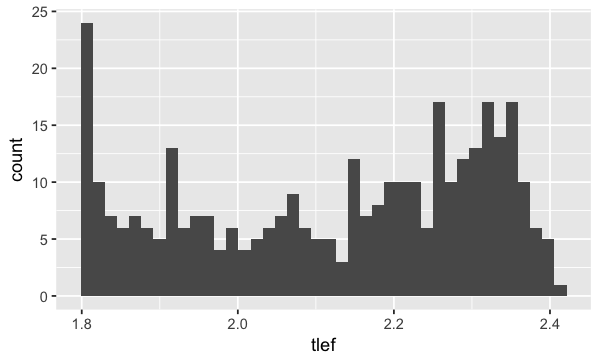

In [28]:
# outcome tnrasformations
adjust_value = 1.8
df[, tle := le/(1.05*max(le))][, tlef := tle - min(tle) + adjust_value]
ggplot(df, aes(tlef)) + geom_histogram(bins=40)

In [29]:
df49 = copy(df)[year < 1950]
df50 = copy(df)[year >= 1950]

In [30]:
# using >=50
data50 = list(
    N = nrow(df50),
    x = df50$gdp, 
    y = df50$tlef,
    le = df50$le,
    minvalue = min(df50$tle, na.rm=TRUE),
    maxvalue = max(df50$le, na.rm=TRUE)
)

saveRDS(data50, '../data/example50.rds')

# Preston Model

## Frequentist

In [31]:
# estimating starting values for the parameters. 
# Assume alpha=1, then estimate logit(yvar)=beta+gamma^GDP

In [32]:
pars = nls(log(y) ~ beta+exp(log(C)*x),
      data=data50,
      start=list(beta=1,C=1))

In [33]:
nlsFormula = "y ~ alpha / (1 + exp( beta + exp(log(C) * x )))"
nlsInitial = c(alpha=max(data50$y),coef(pars)[1],coef(pars)[2])

In [34]:
freq_preston = minpack.lm::nlsLM(formula = nlsFormula,
         data=data50,
         start=nlsInitial,
     control=minpack.lm::nls.lm.control(maxiter=1000))

In [35]:
summary(freq_preston)


Formula: y ~ alpha/(1 + exp(beta + exp(log(C) * x)))

Parameters:
        Estimate Std. Error   t value Pr(>|t|)    
alpha  2.841e+00  8.566e-02    33.163  < 2e-16 ***
beta  -1.564e+00  2.002e-01    -7.814  1.8e-13 ***
C      9.996e-01  9.353e-05 10687.785  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09482 on 237 degrees of freedom

Number of iterations to convergence: 11 
Achieved convergence tolerance: 1.49e-08


In [36]:
freq_pred_values = (predict(freq_preston) - adjust_value  + data50$minvalue) * (1.05 * data50$maxvalue)

In [37]:
summary(freq_pred_values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  53.20   64.65   71.80   70.96   77.39   82.02 

## Stan

In [38]:
stan_preston = '
    data {
      int<lower=0> N; 
      real x[N]; 
      real y[N]; 
    } 
    parameters {
      real alpha; 
      real beta;  
      real<lower=0, upper= 1> C;
      real<lower=0> sigma; 
    } 
    model {
      alpha ~ normal(0, 2); 
      beta ~ normal(0, 2); 
      C ~ uniform(0.5, 1); 
  
      for (i in 1:N) {
        y[i] ~ normal(alpha / ( 1 + exp ( beta + exp ( log(C) * x[i]))), sigma);
      }

      }
    generated quantities{
      real yrep[N];
      real log_lik[N];

      for(i in 1:N){
        yrep[i] = normal_rng(alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma);   
        log_lik[i] = normal_lpdf(y[i] | alpha / ( 1 + exp ( beta + exp (log(C) * x[i]))), sigma);
     }
    }
'

In [39]:
by_preston = stan(model_code = stan_preston, 
            model_name = 'preston', 
            data = data50)

Warning message:
“There were 52 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [1]:
#pairs(fit_preston, pars=c('alpha', 'beta', 'C'))

In [79]:
## apply(extract(bay_preston,'yrep')[[1]], 2, mean)

In [40]:
print(by_preston, pars=c('alpha', 'beta', 'C', 'sigma'))

Inference for Stan model: preston.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha  2.88    0.01 0.15  2.72  2.80  2.86  2.93  3.16   492 1.00
beta  -1.52    0.01 0.26 -1.88 -1.67 -1.54 -1.39 -1.02   657 1.00
C      0.99    0.01 0.04  1.00  1.00  1.00  1.00  1.00    37 1.08
sigma  0.10    0.00 0.01  0.09  0.09  0.10  0.10  0.11    42 1.06

Samples were drawn using NUTS(diag_e) at Thu Mar  8 09:50:35 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [120]:
# leave-one-out
loo_preston = loo(extract_log_lik(by_preston, parameter_name = 'log_lik'))
loo_preston

Warning message:
“Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.”

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    215.8 10.7
p_loo        10.2  1.3
looic      -431.5 21.4

Pareto k diagnostic values:
                         Count  Pct 
(-Inf, 0.5]   (good)     116   48.3%
 (0.5, 0.7]   (ok)        26   10.8%
   (0.7, 1]   (bad)       65   27.1%
   (1, Inf)   (very bad)  33   13.8%
See help('pareto-k-diagnostic') for details.

In [89]:
# predict values
bcSamp = as.matrix(by_preston,pars=c('yrep'))

bcYrep = t(apply(bcSamp, MARGIN = 1, function(x) {
  (x[1:240] - adjust_value  + data50$minvalue) * (1.05 * data50$maxvalue)
}))

In [117]:
# plots
plot1 = plot_predictions(data50$x,data50$le, pred=freq_pred_values) +
    labs(title='preston frequentist') + 
    ylim(30, 95)

In [90]:
plot2 = plot_posterior(bcYrep, x=data50$x, y=data50$le, type='matrix') +
    labs(title='preston bayesian') + 
    ylim(30, 95) 

options(repr.plot.width = 5, repr.plot.height = 3)
plot1 + plot2

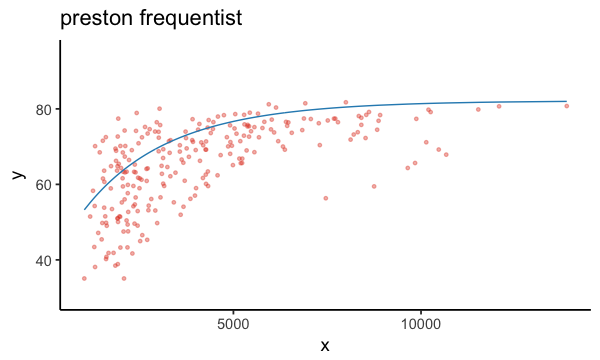

In [118]:
plot1

# Boxcox

## Frequentist

In [14]:
bc = boxcox(data50$y~log(data50$x), plotit=FALSE, lambda=seq(-10,10,0.01))

In [15]:
(lambda = bc$x[bc$y==max(bc$y)])

[1] 5.16

In [16]:
if(lambda==0) {y = log(data50$y)}
if(lambda!=0) {y = (data50$y^lambda -1)/lambda}
freq_boxcox = lm(y ~ log(data50$x))

In [17]:
summary(freq_boxcox)


Call:
lm(formula = y ~ log(data50$x))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.93645 -0.27685  0.01949  0.23315  0.98928 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -3.79452    0.34624  -10.96   <2e-16 ***
log(data50$x)  0.59672    0.04231   14.10   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3715 on 238 degrees of freedom
Multiple R-squared:  0.4553,	Adjusted R-squared:  0.453 
F-statistic: 198.9 on 1 and 238 DF,  p-value: < 2.2e-16


In [18]:
freq_pred_values = (predict(freq_boxcox) - 1  + data50$minvalue) * (1.05 * data50$maxvalue)

## Stan

In [19]:
stan_boxcox = '
    data {
        int<lower=0> N;
        real x[N]; 
        real y[N]; 
    }
    transformed data { 
        vector[N] xlog;
        vector[N] ylog;  
        
        for (n in 1:N) {
          xlog[n] = log(x[n]);
          ylog[n] = log(y[n]);
        }
    }
    parameters {
        real alpha;
        real beta;
        real lambda;
        real<lower=0> sigma;
    }

    model {
        vector[N] y_pow;

        lambda ~ normal(0,3);
        beta ~ normal(0,2);
        alpha ~ normal(0,2);
        sigma ~ cauchy(0,5);

        for (n in 1:N) y_pow[n] = y[n]^lambda;
            (y_pow - 1) / lambda ~ normal(alpha + xlog * beta, sigma);
            target += (lambda - 1) * sum(ylog);
        }

    generated quantities {
        vector[N] log_lik;
        vector[N] yrep;

        for (n in 1:N) {
            log_lik[n] = normal_lpdf(ylog[n] | alpha + xlog[n]*beta, sigma) + (lambda-1)*ylog[n];
            log_lik[n] =  normal_lpdf((y[n]^lambda - 1)/lambda | alpha + xlog[n]*beta, sigma) + (lambda-1)*ylog[n];     
            yrep[n] = normal_rng(alpha + xlog[n]*beta, sigma);

     }
  }
    '

In [ ]:
by_boxcox = stan(model_code = stan_boxcox, 
                 model_name = 'boxcox', 
                 data = data50, 
                 control=list(adapt_delta=.91))

In [21]:
print(by_boxcox, pars=c('alpha', 'beta', 'lambda', 'sigma'))

Inference for Stan model: boxcox.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha  -4.69    0.06 1.25 -7.28 -5.52 -4.62 -3.80 -2.50   441 1.01
beta    0.98    0.01 0.22  0.59  0.82  0.97  1.12  1.43   412 1.01
lambda  4.03    0.02 0.38  3.23  3.77  4.04  4.28  4.73   413 1.01
sigma   0.66    0.01 0.16  0.39  0.55  0.65  0.76  1.03   431 1.01

Samples were drawn using NUTS(diag_e) at Thu Mar  8 09:47:13 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [10]:
loo_boxcox = loo(extract_log_lik(by_boxcox, parameter_name = 'log_lik'))
loo_boxcox

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    239.1 11.9
p_loo         3.2  0.3
looic      -478.3 23.7

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

In [23]:
bcSamp = as.matrix(by_boxcox,pars=c('yrep','lambda'))

bcYrep = t(apply(bcSamp, MARGIN = 1, function(x){
  (x[1:240]*x[241] + 1)^(1/x[241]) - adjust_value  + data50$minvalue
}))

bcYrepf = t(apply(bcYrep, MARGIN = 1, function(x) {
    (x[1:240] * (1.05*data50$maxvalue))
}))

In [25]:
sum(is.na(bcYrepf)) # missing records

[1] 10

In [38]:
compare(loo_preston, loo_boxcox)

elpd_diff        se 
     16.6       5.1 

In [30]:
freq_pred_values = ((predict(freq_boxcox)*lambda+1)^(1/lambda) - 1  + data50$minvalue) * (1.05 * data50$maxvalue)

In [31]:
plot1 = plot_predictions(data50$x, data50$le, freq_pred_values) +
    ylim(30, 95) +
    labs(title='boxcox frequentist')

In [32]:
plot2 = plot_posterior(bcYrepf, data50$x, data50$le, type='matrix') +
    labs(title='boxcox stan') +
    ylim(30, 95)

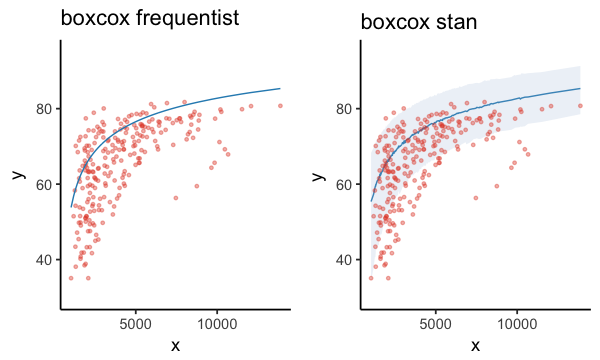

In [33]:
options(repr.plot.width = 5, repr.plot.height = 3)
plot1 + plot2

# Log and quadratic model

Equivalent to the box-cox with lamda = 0.

## Frequentist

In [34]:
freq_log = lm(log(data50$y) ~ 1 + log(data50$x))

In [48]:
summary(freq_log)


Call:
lm(formula = log(data50$y) ~ 1 + log(data50$x))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.227530 -0.039807  0.009745  0.047255  0.161844 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -0.531560   0.066434  -8.001 5.39e-14 ***
log(data50$x)  0.107382   0.008118  13.228  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07127 on 238 degrees of freedom
Multiple R-squared:  0.4237,	Adjusted R-squared:  0.4213 
F-statistic:   175 on 1 and 238 DF,  p-value: < 2.2e-16


In [50]:
freq_pred_values = (exp(predict(freq_log)) - 1  + data50$minvalue) * (1.05 * data50$maxvalue)

In [52]:
summary(freq_pred_values)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  55.45   64.39   70.15   70.67   76.07   89.72 

## Stan

In [62]:
stan_log = '
    data {
        int<lower=0> N;
        real y[N];
        real x[N];
    }
    transformed data { 
        vector[N] xlog;
        vector[N] ylog;  
        
        for (n in 1:N) {
          xlog[n] = log(x[n]);
          ylog[n] = log(y[n]); 
         }
    }
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    model {
        beta ~ normal(0,2);
        alpha ~ normal(0,2);

        for (i in 1:N) {
            ylog[i] ~ normal(alpha + xlog[i]*beta, sigma);
            target += -ylog[i];
        }
    }
    generated quantities {
       vector[N] yrep;
       vector[N] log_lik;
        
        for (n in 1:N) {
        log_lik[n] = normal_lpdf(ylog[n] | alpha +  xlog[n]*beta, sigma) - ylog[n];
        yrep[n] = exp(normal_rng(alpha + xlog[n]*beta, sigma));
        }
    }
    '

In [63]:
by_log = stan(model_code = stan_log, 
            model_name ='log',
            data = data50)

In [64]:
print(by_log, pars=c('alpha', 'beta', 'sigma'))

Inference for Stan model: log.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
alpha -0.53       0 0.07 -0.66 -0.58 -0.53 -0.49 -0.40  1139    1
beta   0.11       0 0.01  0.09  0.10  0.11  0.11  0.12  1138    1
sigma  0.07       0 0.00  0.07  0.07  0.07  0.07  0.08  1742    1

Samples were drawn using NUTS(diag_e) at Thu Mar  8 09:29:16 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [66]:
bcSamp = as.matrix(by_log, pars=c('yrep'))

In [68]:
bcYrep = t(apply(bcSamp, MARGIN = 1, function(x) {
  (x[1:240] - 1  + data50$minvalue) * (1.05 * data50$maxvalue)
}))

sum(is.na(bcYrep)) # missing records

In [30]:
#traceplot(fit_log, pars=c('alpha', 'beta', 'sigma'))

In [47]:
loo_log = loo(extract_log_lik(by_log, parameter_name = 'log_lik'))
loo_log

Computed from 4000 by 240 log-likelihood matrix

         Estimate   SE
elpd_loo    208.5 10.6
p_loo         3.1  0.4
looic      -416.9 21.3

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.

In [76]:
plot1 = plot_predictions(data50$x, data50$le, freq_pred_values) +
    ylim(30, 105) +
    labs(title='boxcox frequentist')

In [77]:
plot2 = plot_posterior(bcYrep, data50$x, data50$le, type='matrix') +
    labs(title='boxcox stan') +
    ylim(30, 105)

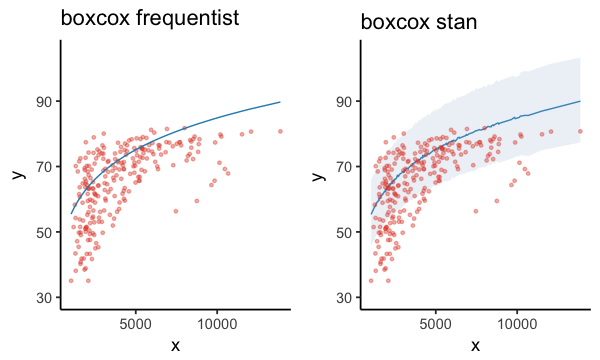

In [78]:
plot1 + plot2

# Averaging or stacking

In [94]:
log_lik_list = list()
log_lik_list[[1]] = extract_log_lik(by_preston, parameter_name = 'log_lik')
log_lik_list[[2]] = extract_log_lik(by_boxcox, parameter_name = 'log_lik') 
log_lik_list[[3]] = extract_log_lik(by_log, parameter_name = 'log_lik') 


In [95]:
w = loo::model_weights(log_lik_list, method='stacking')
print(w)

The stacking weights are:
     [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "1"       "0"      
[1] 3.294094e-08 9.999998e-01 2.074220e-07


In [96]:
loo::model_weights(log_lik_list, method='pseudobma')

The Pseudo-BMA+ weights using Bayesian Bootstrap  are:
      [,1]      [,2]      [,3]     
[1,] "Model 1" "Model 2" "Model 3"
[2,] "0"       "1"       "0"      


[1] 1.364647e-09 9.999993e-01 6.543476e-07

Difference between  models is pretty strong... averaging is giving weight 1 to one of the models (box-cox), in other words, no need to average but to use the best model!

In [115]:
# get combine predictions using stacking

In [107]:
models = list()
models[[1]] = fit_preston
models[[2]] = fit_log
models[[3]] = fit_boxcox

In [97]:
sum(w) # check weights sum 1

[1] 1

In [116]:
options(repr.plot.width = 3, repr.plot.height = 3)

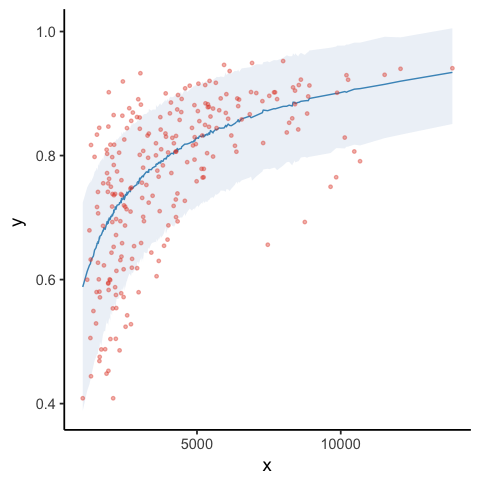

In [117]:
plot_posterior_w(models, w, data$x, data$y)

In [ ]:
# same weight for all models

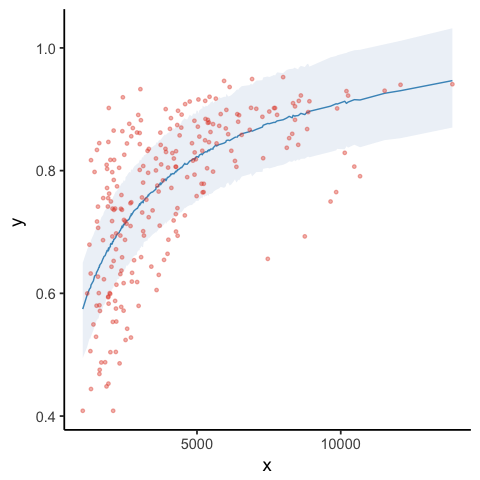

In [121]:
plot_posterior_w(models, rep(1/3, 3), data$x, data$y)